# 1.DataSet

## 1.1 Import Dataset

In [633]:
from torch_geometric.datasets import KarateClub

In [634]:
dataset = KarateClub()
print(f'number of graphs in datasets: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

number of graphs in datasets: 1
Number of features: 34
Number of classes: 4


In [635]:
data = dataset[0] # Get the first graph
data, data.edge_index.t() # get the tuple format of all edge_indexs in the graph

(Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34]),
 tensor([[ 0,  1],
         [ 0,  2],
         [ 0,  3],
         [ 0,  4],
         [ 0,  5],
         [ 0,  6],
         [ 0,  7],
         [ 0,  8],
         [ 0, 10],
         [ 0, 11],
         [ 0, 12],
         [ 0, 13],
         [ 0, 17],
         [ 0, 19],
         [ 0, 21],
         [ 0, 31],
         [ 1,  0],
         [ 1,  2],
         [ 1,  3],
         [ 1,  7],
         [ 1, 13],
         [ 1, 17],
         [ 1, 19],
         [ 1, 21],
         [ 1, 30],
         [ 2,  0],
         [ 2,  1],
         [ 2,  3],
         [ 2,  7],
         [ 2,  8],
         [ 2,  9],
         [ 2, 13],
         [ 2, 27],
         [ 2, 28],
         [ 2, 32],
         [ 3,  0],
         [ 3,  1],
         [ 3,  2],
         [ 3,  7],
         [ 3, 12],
         [ 3, 13],
         [ 4,  0],
         [ 4,  6],
         [ 4, 10],
         [ 5,  0],
         [ 5,  6],
         [ 5, 10],
         [ 5, 16],
         [ 6,  0],
    

## 1.2 Dataset Visualization

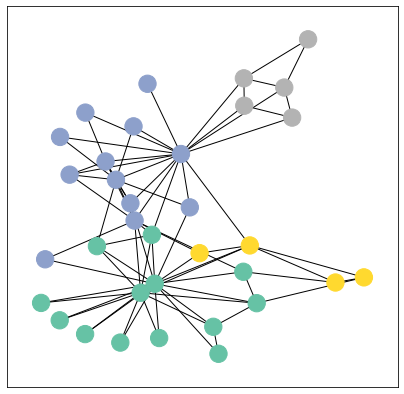

In [636]:
from torch_geometric.utils import to_networkx
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

# 2.Model

## 2.1 Model Definition

In [637]:
import torch
from torch.nn import Linear, Module
from torch_geometric.nn import GCNConv

In [638]:
class GCN(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv1 = GCNConv(input_size, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2) # The output of last GCNConv layer is set to 2, so that we can visualize the embedding h of a node in a 2-dimensional picture.
        self.classifier = Linear(2, output_size)
    
    def forward(self, x, edge_index): # The type of edge_index in GCNConv.forwar(x, edge_index) is union, while our input is tuple.
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh() # the last layer of embedding
        out = self.classifier(h) # the output of classifier

        return out, h

In [639]:
input_size = dataset.num_features
output_size = dataset.num_classes
model = GCN(input_size, output_size)
model

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

## 2.2 The Visualization of Emedding Generated by GCN

The embedding's shape is transfered from torch.Size([34, 34]) to torch.Size([34, 2]), and the embedding can be visualized in 2-dimensional as following:


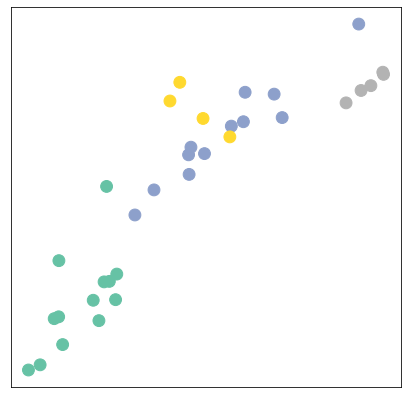

In [640]:
out, h = model(data.x, data.edge_index)
print(f"The embedding's shape is transfered from {data.x.size()} to {h.size()}, and the embedding can be visualized in 2-dimensional as following:")
visualize(h, color=data.y)

In [641]:
# only some of edges is in training set
len(data.train_mask), len(out), data.train_mask, out[data.train_mask]

(34,
 34,
 tensor([ True, False, False, False,  True, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False, False]),
 tensor([[ 0.7703,  0.5842, -0.1823,  0.2725],
         [ 0.7543,  0.6093, -0.1695,  0.2469],
         [ 0.6823,  0.6623, -0.1477,  0.1555],
         [ 0.7272,  0.6014, -0.1779,  0.2236]], grad_fn=<IndexBackward0>))

# 3.Training

## 3.1 Training Setting

In [642]:
args = {
    'lr': 0.01,
    'epochs': 1000,
}
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

## 3.2 Start Training

In [643]:
def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # only calculate the loss of traninig set
    loss.backward()
    optimizer.step()
    return loss, h

In [644]:
def accuracy():
    out, h = model(data.x, data.edge_index)
    pred = out
    label = data.y

    pred_train = pred[data.train_mask]
    pred_train = torch.nn.functional.softmax(pred_train).argmax(axis=0).reshape(-1, 1)
    label_train = label[data.train_mask]
    acc = (pred_train == label_train).sum() / len(pred_train)
    
    return acc

In [645]:
for epoch in range(args['epochs']):
    loss, h = train(data)
    # print(h.shape)
    # print(data.y.shape)
    acc = accuracy()
    if epoch % 10 == 0:
        print(f"epoch :{epoch}, loss: {loss}, accuracy: {acc}")
        # visualize(h, color=data.y, epoch=epoch, loss=loss)

epoch :0, loss: 1.4628229141235352, accuracy: 1.0


/var/folders/gy/zjs2ncbs7y97_x8_t1hh7wcr0000gn/T/ipykernel_19273/176563386.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_train = torch.nn.functional.softmax(pred_train).argmax(axis=0).reshape(-1, 1)


epoch :10, loss: 1.3339279890060425, accuracy: 1.0
epoch :20, loss: 1.1707860231399536, accuracy: 1.0
epoch :30, loss: 0.9718849658966064, accuracy: 1.0
epoch :40, loss: 0.8277209997177124, accuracy: 1.0
epoch :50, loss: 0.758748471736908, accuracy: 1.0
epoch :60, loss: 0.7290096282958984, accuracy: 1.0
epoch :70, loss: 0.7134761810302734, accuracy: 1.0
epoch :80, loss: 0.6993587613105774, accuracy: 1.0
epoch :90, loss: 0.680239200592041, accuracy: 1.0
epoch :100, loss: 0.655189037322998, accuracy: 1.0
epoch :110, loss: 0.6252906322479248, accuracy: 1.0
epoch :120, loss: 0.5915474891662598, accuracy: 1.0
epoch :130, loss: 0.5552318096160889, accuracy: 1.0
epoch :140, loss: 0.5191514492034912, accuracy: 1.0
epoch :150, loss: 0.48576492071151733, accuracy: 1.0
epoch :160, loss: 0.45577019453048706, accuracy: 1.0
epoch :170, loss: 0.42675328254699707, accuracy: 1.0
epoch :180, loss: 0.39462411403656006, accuracy: 1.0
epoch :190, loss: 0.35920485854148865, accuracy: 1.0
epoch :200, loss: 0